<a href="https://colab.research.google.com/github/Ssurf777/physics_informed_neural_network/blob/main/PINNS_heat_diffusion20240825.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

熱源[1,1,1]の時の温度分布

tensor([[ 0.3000,  0.8247, -0.4795],
        [ 0.9222,  0.0469, -0.3838],
        [-0.6504,  0.0741,  0.7560],
        ...,
        [-0.5653,  0.6796,  0.4675],
        [ 0.7436,  0.6608, -0.1020],
        [ 0.4192, -0.7846,  0.4568]])
Epoch 0, Loss: 0.010172256651327472
Epoch 10, Loss: 0.0005072974020132879
Epoch 20, Loss: 0.00018428367060499795
Epoch 30, Loss: 0.00023431094383258432
Epoch 40, Loss: 0.00011900362374717233
Epoch 50, Loss: 0.00024133792187257263
Epoch 60, Loss: 0.00016722133780684877
Epoch 70, Loss: 8.608409209487355e-05
Epoch 80, Loss: 0.00011670546398038084
Epoch 90, Loss: 0.00020703545478616725


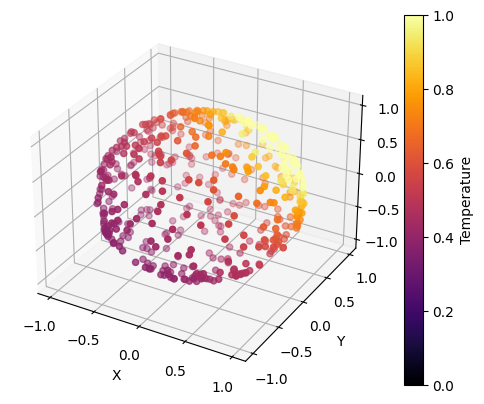

In [ ]:
# ライブラリインポート
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# モデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 点群生成とクラスター化
#def create_points(num_points=100):
#    return torch.rand((num_points, 3))

# 点群生成とクラスター化
def create_points(num_points=500, radius=1.0):
    theta = torch.rand(num_points) * 2 * torch.pi  # 0から2πの範囲でランダムに生成
    phi = torch.acos(2 * torch.rand(num_points) - 1)  # 0からπの範囲でランダムに生成

    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    return torch.stack([x, y, z], dim=1)

# 使用例
points = create_points(num_points=500)
print(points)

def create_clusters(points, k=4):
    clusters = []
    for i, point in enumerate(points):
        distances = torch.norm(points - point, dim=1)
        closest_neighbors_idx = torch.topk(distances, k+1, largest=False)[1][1:]  # 自身を除外する
        cluster = points[closest_neighbors_idx]
        clusters.append(cluster)
    return clusters

# ラプラシアンの計算
def compute_laplacian_with_clusters(model, clusters):
    laplacians = []
    for cluster in clusters:
        cluster.requires_grad_(True)
        T = model(cluster)

        grad_T = torch.autograd.grad(outputs=T, inputs=cluster,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True)[0]

        laplacian = 0
        for i in range(cluster.shape[1]):
            grad2_T = torch.autograd.grad(grad_T[:, i], cluster,
                                          grad_outputs=torch.ones_like(grad_T[:, i]),
                                          create_graph=True, retain_graph=True)[0][:, i] # retain_graph=Trueを追加
            laplacian += grad2_T

        laplacians.append(laplacian.mean())  # クラスター全体での平均を取る
    return torch.stack(laplacians)

# PINNの学習
def train_pinn_with_clusters(model, points, heat_source, epochs=100, k=4):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    clusters = create_clusters(points, k=k)

    for epoch in range(epochs):
        model.train()

        total_loss = 0

        for i, point in enumerate(points):
            distance_to_source = torch.norm(point - heat_source)  # 熱源からの距離
            expected_temperature = 1 / (distance_to_source + 1e-8)  # 距離に基づく温度 (逆比例)

            # Compute Laplacian inside the loop and retain the graph
            laplacian = compute_laplacian_with_clusters(model, [clusters[i]]) # Compute for the current cluster only

            # 熱拡散方程式に基づく損失
            loss_laplacian = torch.mean((laplacian[0]) ** 2)  # ラプラシアン項の損失
            loss_temperature = torch.mean((model(point.unsqueeze(0)) - expected_temperature) ** 2)  # 温度分布の損失

            loss = loss_laplacian + loss_temperature  # 合計損失
            total_loss += loss.item()

            # 逆伝播と最適化
            optimizer.zero_grad()
            loss.backward(retain_graph=True) # Retain the graph for subsequent backpropagations
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss/len(points)}')

# 推論と可視化
def infer_and_visualize(model, points):
    with torch.no_grad():
        temperatures = model(points).cpu().numpy()

    # 3Dコンターのプロット
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = points[:, 0].cpu().numpy()
    y = points[:, 1].cpu().numpy()
    z = points[:, 2].cpu().numpy()

    # 3Dグリッド作成
    grid_x, grid_y, grid_z = np.mgrid[0:1:100j, 0:1:100j, 0:1:100j] # 3Dグリッド
    grid_temp = griddata(np.vstack((x, y, z)).T, temperatures.flatten(), (grid_x, grid_y, grid_z), method='linear') # 3Dグリッドで補間

    # 温度で色付けした点群プロット
    #scatter = ax.scatter(x, y, z, c=temperatures.flatten(), cmap='inferno')
    #fig.colorbar(scatter, ax=ax, label='Temperature')

    # 温度で色付けした点群プロット（0～1で色付け固定）
    scatter = ax.scatter(x, y, z, c=temperatures.flatten(), cmap='inferno', vmin=0, vmax=1)
    fig.colorbar(scatter, ax=ax, label='Temperature')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# 使用例
points = create_points()
model = PINN()
train_pinn_with_clusters(model, points, torch.tensor([1, 1, 1]))  # 任意の熱源を中央に設定
infer_and_visualize(model, points)


熱源[-1,-1,-1]の時の温度分布

tensor([[ 0.0145, -0.8226,  0.5685],
        [ 0.2946, -0.8746,  0.3850],
        [ 0.4355,  0.0140, -0.9001],
        ...,
        [ 0.4461, -0.4050, -0.7981],
        [-0.1253,  0.2529, -0.9593],
        [-0.4879, -0.5252, -0.6972]])
Epoch 0, Loss: 0.019755540428434137
Epoch 10, Loss: 0.0002657744476442545
Epoch 20, Loss: 0.00021885564095536835
Epoch 30, Loss: 0.00020049331446971407
Epoch 40, Loss: 0.0002213018027682896
Epoch 50, Loss: 6.574561414247704e-05
Epoch 60, Loss: 0.0001072954204361256
Epoch 70, Loss: 0.00018525906300878957
Epoch 80, Loss: 6.300546779992722e-05
Epoch 90, Loss: 5.495839242519729e-05


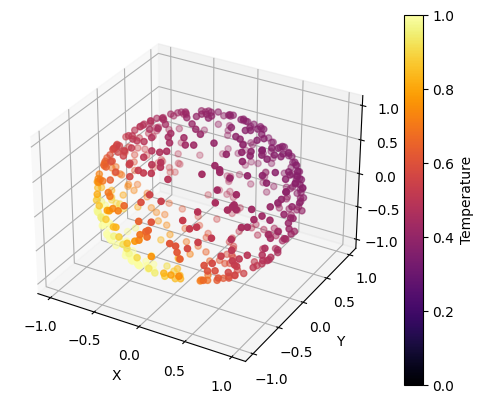

In [ ]:
# ライブラリインポート
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# モデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 点群生成とクラスター化
#def create_points(num_points=100):
#    return torch.rand((num_points, 3))

# 点群生成とクラスター化
def create_points(num_points=500, radius=1.0):
    theta = torch.rand(num_points) * 2 * torch.pi  # 0から2πの範囲でランダムに生成
    phi = torch.acos(2 * torch.rand(num_points) - 1)  # 0からπの範囲でランダムに生成

    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    return torch.stack([x, y, z], dim=1)

# 使用例
points = create_points(num_points=500)
print(points)

def create_clusters(points, k=4):
    clusters = []
    for i, point in enumerate(points):
        distances = torch.norm(points - point, dim=1)
        closest_neighbors_idx = torch.topk(distances, k+1, largest=False)[1][1:]  # 自身を除外する
        cluster = points[closest_neighbors_idx]
        clusters.append(cluster)
    return clusters

# ラプラシアンの計算
def compute_laplacian_with_clusters(model, clusters):
    laplacians = []
    for cluster in clusters:
        cluster.requires_grad_(True)
        T = model(cluster)

        grad_T = torch.autograd.grad(outputs=T, inputs=cluster,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True)[0]

        laplacian = 0
        for i in range(cluster.shape[1]):
            grad2_T = torch.autograd.grad(grad_T[:, i], cluster,
                                          grad_outputs=torch.ones_like(grad_T[:, i]),
                                          create_graph=True, retain_graph=True)[0][:, i] # retain_graph=Trueを追加
            laplacian += grad2_T

        laplacians.append(laplacian.mean())  # クラスター全体での平均を取る
    return torch.stack(laplacians)

# PINNの学習
def train_pinn_with_clusters(model, points, heat_source, epochs=100, k=4):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    clusters = create_clusters(points, k=k)

    for epoch in range(epochs):
        model.train()

        total_loss = 0

        for i, point in enumerate(points):
            distance_to_source = torch.norm(point - heat_source)  # 熱源からの距離
            expected_temperature = 1 / (distance_to_source + 1e-8)  # 距離に基づく温度 (逆比例)

            # Compute Laplacian inside the loop and retain the graph
            laplacian = compute_laplacian_with_clusters(model, [clusters[i]]) # Compute for the current cluster only

            # 熱拡散方程式に基づく損失
            loss_laplacian = torch.mean((laplacian[0]) ** 2)  # ラプラシアン項の損失
            loss_temperature = torch.mean((model(point.unsqueeze(0)) - expected_temperature) ** 2)  # 温度分布の損失

            loss = loss_laplacian + loss_temperature  # 合計損失
            total_loss += loss.item()

            # 逆伝播と最適化
            optimizer.zero_grad()
            loss.backward(retain_graph=True) # Retain the graph for subsequent backpropagations
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss/len(points)}')

# 推論と可視化
def infer_and_visualize(model, points):
    with torch.no_grad():
        temperatures = model(points).cpu().numpy()

    # 3Dコンターのプロット
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = points[:, 0].cpu().numpy()
    y = points[:, 1].cpu().numpy()
    z = points[:, 2].cpu().numpy()

    # 3Dグリッド作成
    grid_x, grid_y, grid_z = np.mgrid[0:1:100j, 0:1:100j, 0:1:100j] # 3Dグリッド
    grid_temp = griddata(np.vstack((x, y, z)).T, temperatures.flatten(), (grid_x, grid_y, grid_z), method='linear') # 3Dグリッドで補間

    # 温度で色付けした点群プロット
    #scatter = ax.scatter(x, y, z, c=temperatures.flatten(), cmap='inferno')
    #fig.colorbar(scatter, ax=ax, label='Temperature')

    # 温度で色付けした点群プロット（0～1で色付け固定）
    scatter = ax.scatter(x, y, z, c=temperatures.flatten(), cmap='inferno', vmin=0, vmax=1)
    fig.colorbar(scatter, ax=ax, label='Temperature')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# 使用例
points = create_points()
model = PINN()
train_pinn_with_clusters(model, points, torch.tensor([-1, -1, -1]))  # 任意の熱源を中央に設定
infer_and_visualize(model, points)
